In [124]:
!pip install 'dtreeviz'
!pip install pydotplus

In [125]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import dtreeviz.trees as dtreeviz

import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import Polygon

import matplotlib
import subprocess
from io import StringIO
import pydotplus
from PIL import Image

from sklearn import tree
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, make_scorer, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

In [126]:
train_XY_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021_train_XY_preprocesado.csv'
df_train_so = pd.read_csv(train_XY_url)
test_XY_url = 'https://minio-api.all.ar/orga-datos/properati_argentina_2021_test_XY_preprocesado.csv'
df_test_XY = pd.read_csv(test_XY_url)

#Clasificación

En esta sección vamos a otorgarle a cada propiedad, un tipo de precio; bajo, medio, alto. Vamos a intentar predecir dicho parámetro estudiando primero, el precio por metro cuadrado.


In [127]:
zona_df = df_train_so.copy()

#Creamos la columna pxm2 dividiendo el precio de cada propiedad por su superficie total. Nos toca ahora hacer las distintas asignaciones
zona_df["pxm2"] = [p / m for p, m in zip(zona_df["property_price"], zona_df["property_surface_total"])]
#zona_df

##Gráficos.

Ahora, vamos a graficar la distribución del precio por metro cuadrado en general y por tipo de propiedad. Notamos en el punto anterior que a partir de 8000USD/m2 hay una caída en la cantidad de avisos, por lo tanto mostraremos la distribución de publicaciones de menos de 8000USD/m2 en un gráfico y de más, en otro:

[Text(0.5, 1.0, 'Distribución de precio por metro cuadrado mayor a 8000USD/m2'),
 Text(0.5, 0, 'Precio por metro cuadrado (USD)'),
 Text(0, 0.5, 'Cantidad publicaciones')]

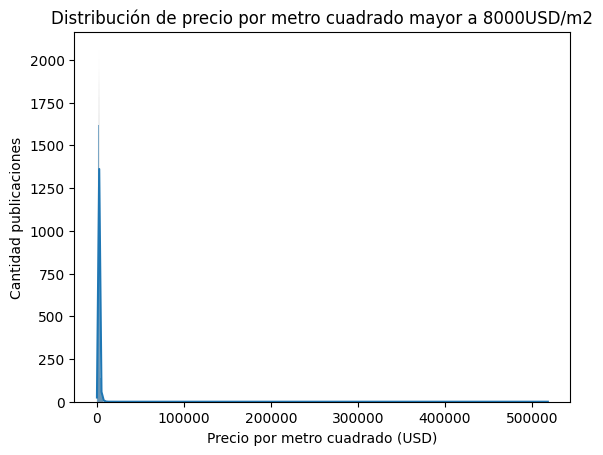

In [128]:
sns.histplot(data=zona_df["pxm2"], kde=True, alpha = 0.5).set(title="Distribución de precio por metro cuadrado mayor a 8000USD/m2",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")

Ahora, vamos a ver cómo cambia según el tipo de propiedad:


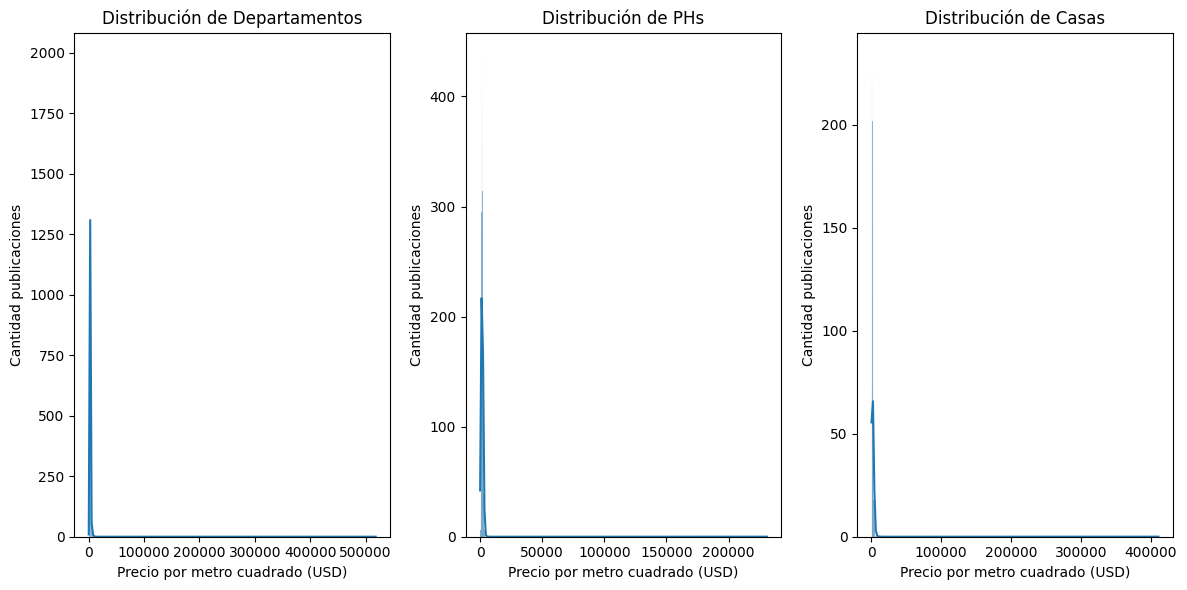

In [129]:
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

sns.histplot(data=zona_df[(zona_df["property_type"]) == "Departamento"]["pxm2"], kde=True, alpha = 0.5, ax=axes[0]).set(title="Distribución de Departamentos",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "PH"]["pxm2"], kde=True, alpha = 0.5, ax=axes[1]).set(title="Distribución de PHs",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
sns.histplot(data=zona_df[(zona_df["property_type"]) == "Casa"]["pxm2"], kde=True, alpha = 0.5, ax=axes[2]).set(title="Distribución de Casas",xlabel="Precio por metro cuadrado (USD)",ylabel="Cantidad publicaciones")
plt.tight_layout()
plt.show()

## Variable *tipo_precio*

Vamos a dividir nuestro dataset y asignar a cada división, una etiqueta según el precio publicado. Las etiquetas serán Bajo, Medio, Alto. En primera instancia será una división equitativa, luego serán 25%, 50% y 25% y para lo último haremos ese mismo análisis discriminando por tipo de propiedad.

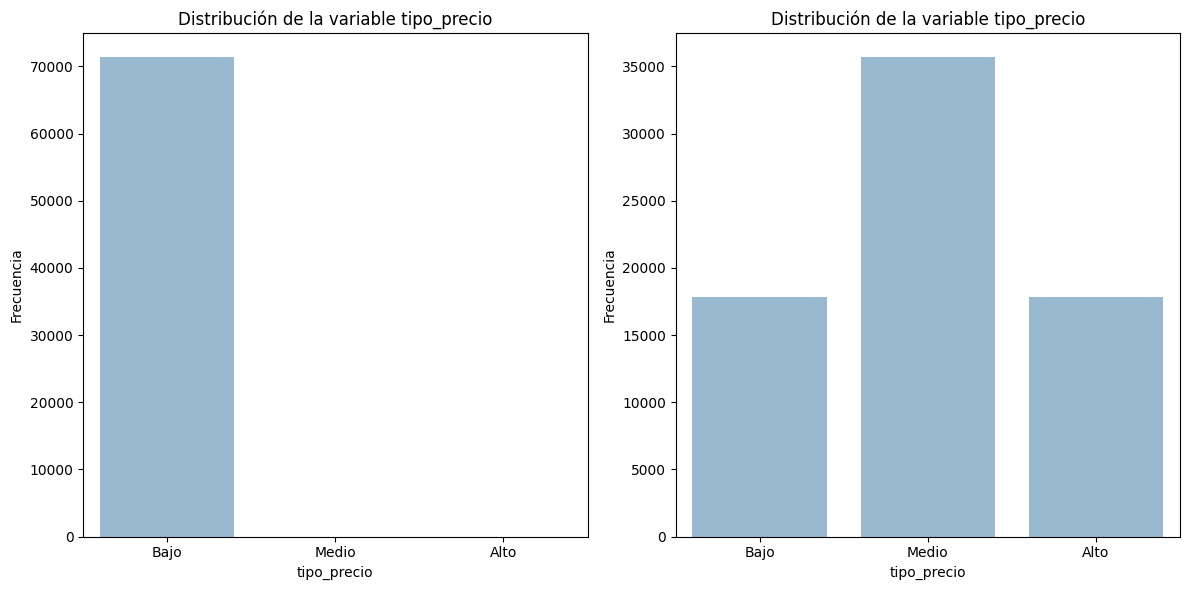

In [130]:
quantiles = [0, 0.25, 0.75, 1]
labels = ['Bajo', 'Medio', 'Alto']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

zona_df['tipo_precio'] = pd.cut(zona_df['pxm2'], bins=3, labels=labels) #divide en 3 la variable pxm2
#zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=3, labels=labels) #divide en 3 la frecuencia
df_agrupado_Tprecio1 = zona_df.groupby(["tipo_precio"]).count()

zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels)
df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

eje_x1 = df_agrupado_Tprecio1["pxm2"].tolist()
eje_y1 = df_agrupado_Tprecio1.index.tolist()
eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
eje_y2 = df_agrupado_Tprecio2.index.tolist()

#cambio x por y para hacer el gráfico vertical

sns.barplot(y=eje_x1, x=eje_y1, data=df_agrupado_Tprecio1 ,alpha=0.5, ax = axes[0]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax = axes[1]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')

plt.tight_layout()
plt.show()

Con estas visualizaciones, se nos hace más fácil entender la distribución de los precios en las propiedades. Elegimos la representación 2 (la de tres intervalos divididos por cuartiles) como la mejor opción para trabajar porque:
* A diferencia de la 1, no es sensible a que las categorías sean muy pequeñas por la existencia de escasas propiedades muy caras (se puede ver la gran diferencia de la cantidad de propiedades de peso "alto" comparado a las otras)
* A diferencia de la 3, podremos usar el tipo de propiedad como un atributo que nos ayudará a predecir el rango de precio en el que una propiedad podría estar.

Añadimos tipo_precio al conjunto de Test:


In [131]:
limite_bajo_medio = np.quantile(zona_df['pxm2'], 0.25)
limite_bajo_medio

1777.4107134771093

In [132]:
limite_medio_alto = np.quantile(zona_df['pxm2'], 0.75)
limite_medio_alto

2756.0975609756097

In [133]:
x_test_y_test = df_test_XY.copy()

x_test_y_test["pxm2"] = [p / m for p, m in zip(x_test_y_test["property_price"], x_test_y_test["property_surface_total"])]
x_test_y_test.loc[x_test_y_test["pxm2"] <= limite_bajo_medio, 'tipo_precio'] = "Bajo"
x_test_y_test.loc[(x_test_y_test["pxm2"] > limite_bajo_medio) & (x_test_y_test["pxm2"] <= limite_medio_alto), 'tipo_precio'] = "Medio"
x_test_y_test.loc[x_test_y_test["pxm2"] > limite_medio_alto, 'tipo_precio'] = "Alto"

x_test_y_test.head(3)

,start_date,end_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_title,property_price,pxm2,tipo_precio
0,2021-09-07,2022-03-06,-34.572507,-58.447047,Colegiales,Departamento,3.0,2.0,65.0,56.0,3 ambientes con vista totalmente abierta . Ent...,248000.0,3815.384615,Alto
1,2021-10-01,2022-02-09,-34.599391,-58.372185,Retiro,Departamento,3.0,2.0,51.0,51.0,Depto venta 3 amb 51m2 Retiro OPORTUNIDAD,85000.0,1666.666667,Bajo
2,2021-09-22,2022-03-09,-34.576547,-58.431213,Palermo,Departamento,4.0,3.0,89.0,81.0,"Excelente departamento 4 ambientes, piso alto,...",240000.0,2696.629213,Medio


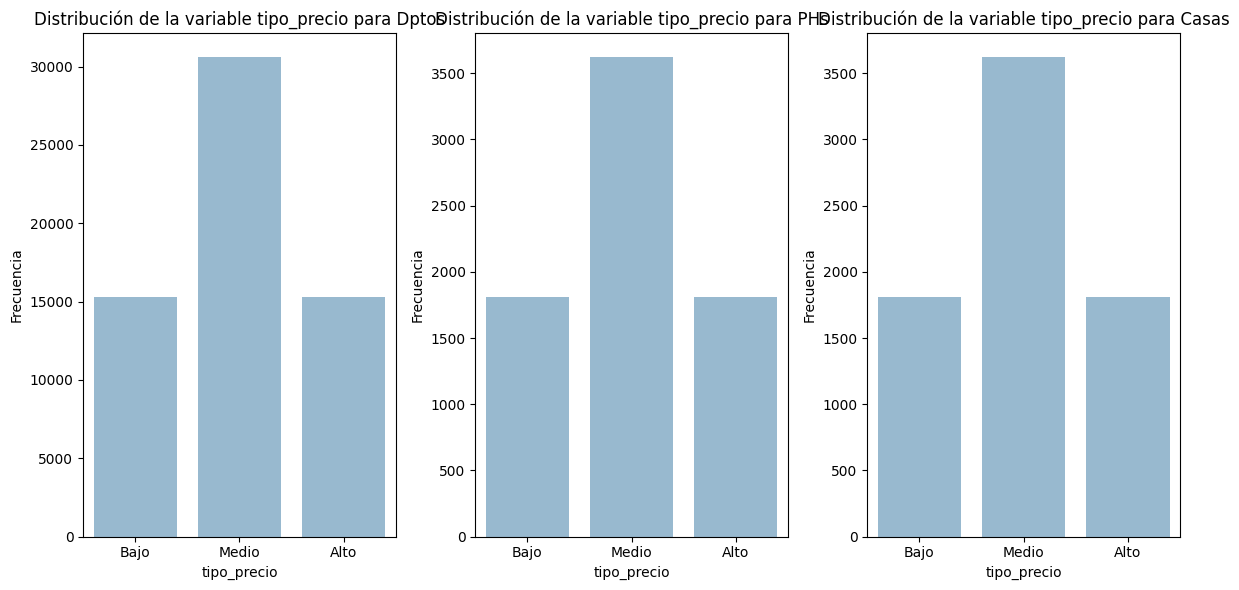

In [134]:
quantiles = [0, 0.25, 0.75, 1]
labels = ['Bajo', 'Medio', 'Alto']
fig, axes = plt.subplots(1, 3, figsize=(12, 6))

zona_df['tipo_precio'] = pd.qcut(zona_df[(zona_df["property_type"]) == "Departamento"]["pxm2"], q=quantiles, labels=labels) #divide en 3 la frecuencia
df_agrupado_Tprecio1 = zona_df.groupby(["tipo_precio"]).count()

zona_df['tipo_precio'] = pd.qcut(zona_df[(zona_df["property_type"]) == "PH"]["pxm2"], q=quantiles, labels=labels)
df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

zona_df['tipo_precio'] = pd.qcut(zona_df[(zona_df["property_type"]) == "Casa"]["pxm2"], q=quantiles, labels=labels)
df_agrupado_Tprecio3 = zona_df.groupby(["tipo_precio"]).count()

eje_x1 = df_agrupado_Tprecio1["pxm2"].tolist()
eje_y1 = df_agrupado_Tprecio1.index.tolist()
eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
eje_y2 = df_agrupado_Tprecio2.index.tolist()
eje_x3 = df_agrupado_Tprecio3["pxm2"].tolist()
eje_y3 = df_agrupado_Tprecio3.index.tolist()

#cambio x por y para hacer el gráfico vertical

sns.barplot(y=eje_x1, x=eje_y1, data=df_agrupado_Tprecio1 ,alpha=0.5, ax = axes[0]).\
  set(title="Distribución de la variable tipo_precio para Dptos",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax = axes[1]).\
  set(title="Distribución de la variable tipo_precio para PHs",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x2, x=eje_y2, data=df_agrupado_Tprecio3 ,alpha=0.5, ax = axes[2]).\
  set(title="Distribución de la variable tipo_precio para Casas",ylabel='Frecuencia',xlabel='tipo_precio')

plt.tight_layout()
plt.show()

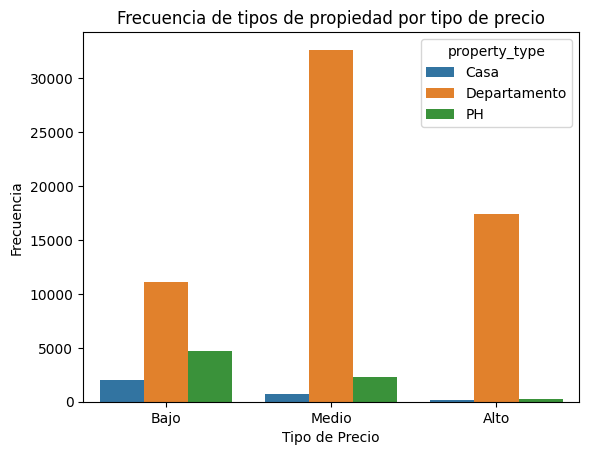

In [135]:
zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels)
df_agrupado_Tprecio = zona_df.groupby(["tipo_precio", "property_type"]).size().reset_index(name='count')

sns.barplot(data=df_agrupado_Tprecio, x='tipo_precio', y='count', hue='property_type')

plt.title('Frecuencia de tipos de propiedad por tipo de precio')
plt.xlabel('Tipo de Precio')
plt.ylabel('Frecuencia')
plt.show()


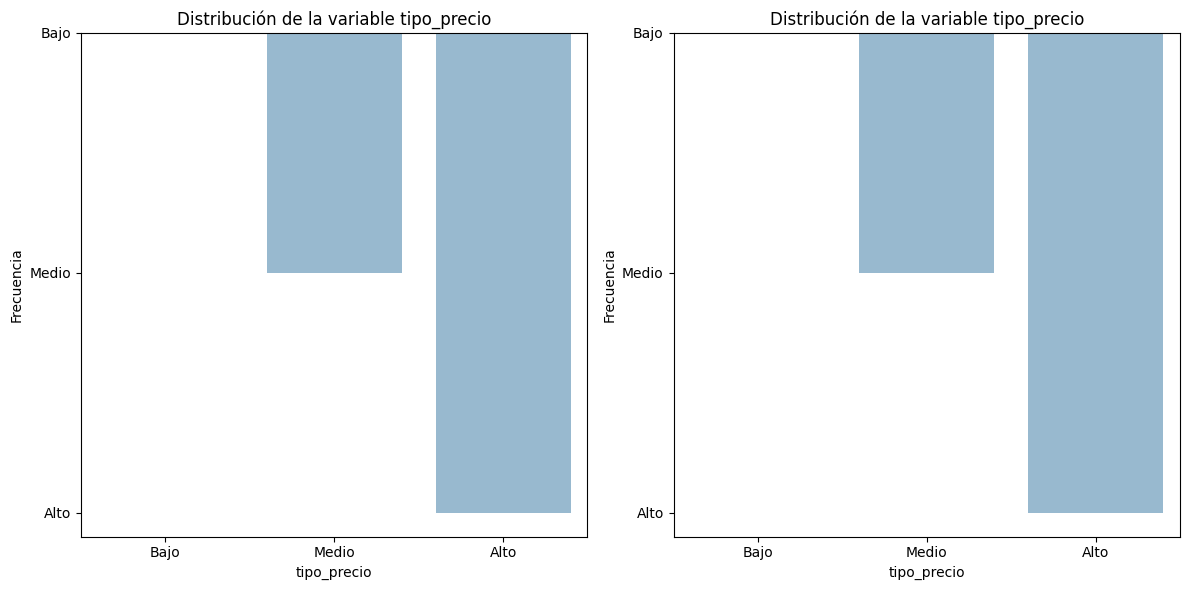

In [136]:
#comparacion con kmeans

quantiles = [0, 0.25, 0.75, 1]
kmeans_groups = labels.copy()
labels_nombres = ['Bajo', 'Medio', 'Alto']
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

zona_df['tipo_precio'] = pd.qcut(zona_df['pxm2'], q=quantiles, labels=labels_nombres)
df_agrupado_Tprecio2 = zona_df.groupby(["tipo_precio"]).count()

eje_x2 = df_agrupado_Tprecio2["pxm2"].tolist()
eje_x1 = kmeans_groups
eje_y2 = df_agrupado_Tprecio2.index.tolist()

sns.barplot(y=eje_x1, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax=axes[0]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')
sns.barplot(y=eje_x1, x=eje_y2, data=df_agrupado_Tprecio2 ,alpha=0.5, ax=axes[1]).\
  set(title="Distribución de la variable tipo_precio",ylabel='Frecuencia',xlabel='tipo_precio')

plt.tight_layout()
plt.show()

<ipython-input-137-fc854a12f348>:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



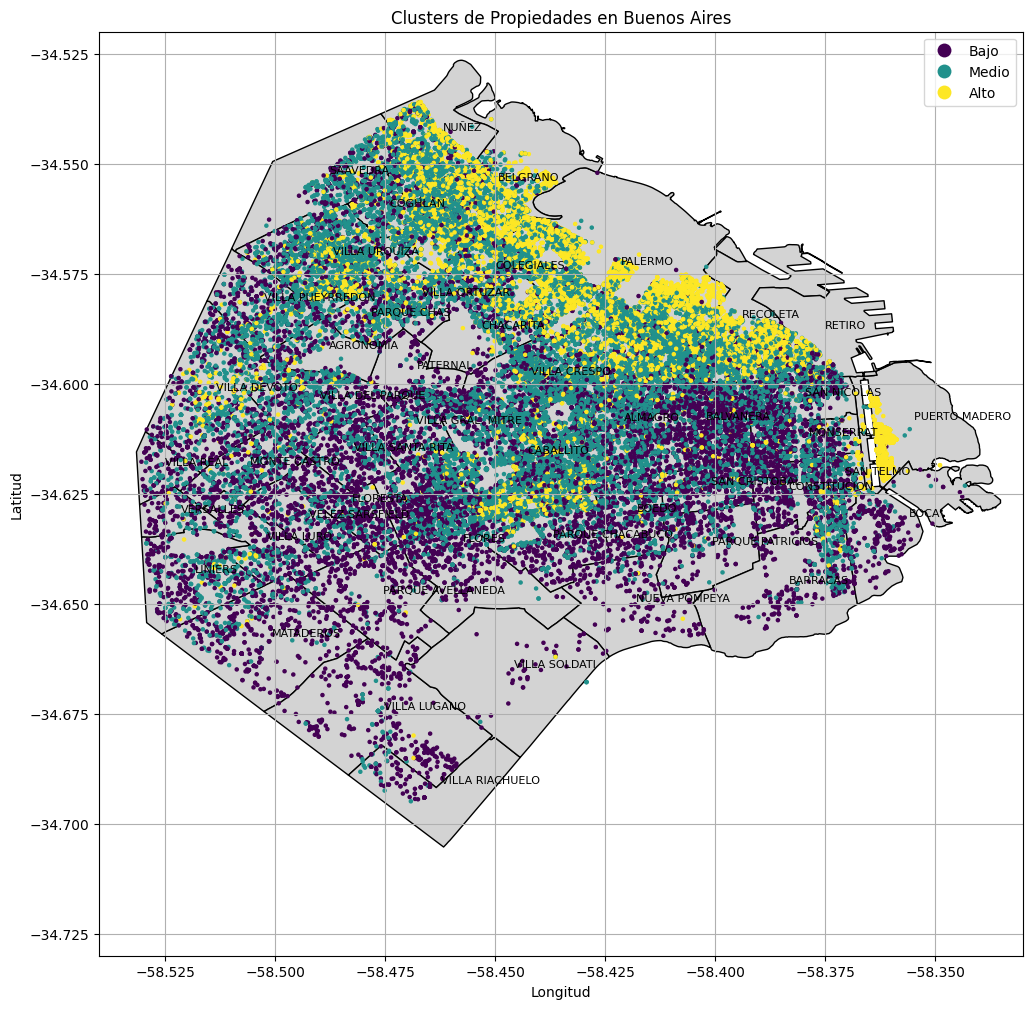

In [137]:
geometry = [Point(xy) for xy in zip(zona_df['longitud'], zona_df['latitud'])]

gdf_clusters = gpd.GeoDataFrame(zona_df, geometry=geometry)

url = 'https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson'
gdf_barrios = gpd.read_file(url)

gdf_caba = gdf_barrios[gdf_barrios['COMUNA'].astype(int) <= 15]

fig, ax = plt.subplots(figsize=(12, 12))
gdf_caba.plot(ax=ax, color='lightgray', edgecolor='black')

gdf_clusters.plot(ax=ax, column='tipo_precio', cmap='viridis', markersize=5, legend=True)

for x, y, label in zip(gdf_caba.geometry.centroid.x, gdf_caba.geometry.centroid.y, gdf_caba['BARRIO']):
    ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", fontsize=8)

ax.set_title('Clusters de Propiedades en Buenos Aires')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.set_xlim([-58.54, -58.33])
ax.set_ylim([-34.73, -34.52])
ax.grid(True)

plt.show()

Con estas visualizaciones, se nos hace más fácil entender la distribución de los precios en las propiedades. Elegimos la última representación como la mejor opción para trabajar porque consideramos importante discriminar el tipo de propiedad.

#Entrenamiento y predicción

Vamos a implementar tres modelos, siendo los dos primeros un Árbol de decisión y Random Forest para intentar predecir el tipo de precio de una propiedad según la información brindada por el dataset. Excluiremos cualquier variable que tenga información sobre el precio, por lo tanto, las variables *pxm2* y *property_price* no estarán en el dataset utilizado para el entrenamiento.
El paso siguiente será separar el dataframe en dos partes, siendo la primera los datos con los que cuenta el arbol y la segunda los datos a predecir. A su vez, estas dos partes serán distinguidas como "x" e "y", siendo "y" la variable target, en este caso la variable *tipo_precio*.
Además de esto, vemos que las columnas *end_date*, *start_date* y *property_title* no aportan información significativa a la predicción. Las eliminamos.
Por último, la columna *property_type* es de tipo String, por lo que vamos a utilizar One Hot Econding para trabajar con el tipo de propiedad en valores numéricos para que pueda ser interpretado por nuestro árbol.

#Árbol de decisión

Crearemos un árbol base para ver cómo se comporta y qué resultados obtenemos para mejorarlos.


In [163]:
#saco columnas con información acerca del precio y uso la variable tipo_precio como target


ds_properti_arbol = zona_df.copy() #zona_df es el conjunto de entrenamiento

#me llega x_test_y_test de afuera para predecir el modelo.

columnas_a_borrar = ["property_price", "pxm2", "tipo_precio", "end_date", "start_date", "property_title", "place_l3"]

#encoding variable property_type
# ds_properti_arbol = pd.get_dummies(ds_properti_arbol, columns=["property_type"], drop_first=True)

x_train = ds_properti_arbol.drop(columnas_a_borrar, axis="columns", inplace=False)

x_train = pd.get_dummies(x_train, columns=["property_type"], drop_first=True)

y_train = ds_properti_arbol["tipo_precio"].copy()

x_test = x_test_y_test.drop(columnas_a_borrar, axis="columns", inplace=False)

x_test = pd.get_dummies(x_test, columns=["property_type"], drop_first=True)

y_test = x_test_y_test["tipo_precio"].copy()


In [164]:
x_train.head(5)

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_type_Departamento,property_type_PH
0,-34.630337,-58.411793,2.0,1.0,139.000000,61.0,True,False
1,-34.637319,-58.361124,3.0,2.0,58.000000,55.0,True,False
2,-34.597205,-58.392474,3.0,2.0,133.000000,92.0,True,False
3,-34.590503,-58.408862,4.0,3.0,81.189696,67.0,True,False
4,-34.579388,-58.436085,1.0,1.0,25.000000,20.0,True,False


In [165]:
y_test.head(5)

0     Alto
1     Bajo
2    Medio
3    Medio
4     Bajo
Name: tipo_precio, dtype: object

In [166]:
ds_properti_arbol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71424 entries, 0 to 71423
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   start_date                71424 non-null  object  
 1   end_date                  71424 non-null  object  
 2   latitud                   71424 non-null  float64 
 3   longitud                  71424 non-null  float64 
 4   place_l3                  71424 non-null  object  
 5   property_type             71424 non-null  object  
 6   property_rooms            71424 non-null  float64 
 7   property_bedrooms         71424 non-null  float64 
 8   property_surface_total    71424 non-null  float64 
 9   property_surface_covered  71424 non-null  float64 
 10  property_title            71424 non-null  object  
 11  property_price            71424 non-null  float64 
 12  pxm2                      71424 non-null  float64 
 13  tipo_precio               71424 non-null  cate

In [167]:
#Creo arbol básico
modelo_arbol = tree.DecisionTreeClassifier()

modelo = modelo_arbol.fit(X = x_train, y= y_train)

In [168]:
y_pred = modelo.predict(x_test)
y_pred

array(['Alto', 'Bajo', 'Medio', ..., 'Alto', 'Medio', 'Alto'],
      dtype=object)

In [169]:
resultados = pd.DataFrame(zip(y_test, y_pred), columns = ["test", "pred"])
resultados.head(10)

,test,pred
0,Alto,Alto
1,Bajo,Bajo
2,Medio,Medio
3,Medio,Medio
4,Bajo,Medio
5,Medio,Bajo
6,Bajo,Bajo
7,Bajo,Bajo
8,Alto,Alto
9,Bajo,Bajo


Text(50.722222222222214, 0.5, 'True')

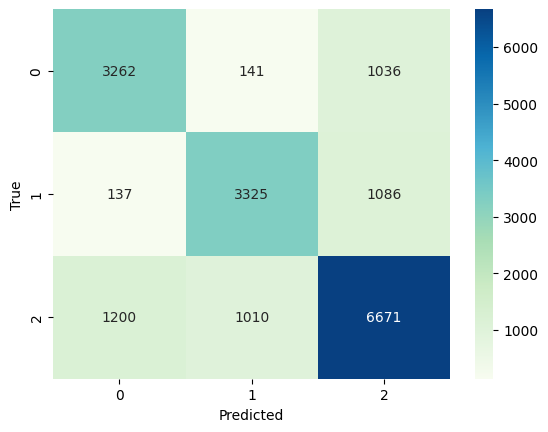

In [170]:
#Matriz de confusión

tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap = "GnBu", annot = True, fmt = "g")
plt.xlabel('Predicted')
plt.ylabel('True')

In [171]:
# accuracy=accuracy_score(y_test,y_pred)
# recall=recall_score(y_test,y_pred, average = "macro")
# f1=f1_score(y_test,y_pred, average = "macro")
# precision=precision_score(y_test,y_pred, average = "macro")

# print("Accuracy: "+str(accuracy))
# print("Recall: "+str(recall))
# print("Precision: "+str(precision))
# print("f1 score: "+str(f1))

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Alto       0.71      0.73      0.72      4439
        Bajo       0.74      0.73      0.74      4548
       Medio       0.76      0.75      0.75      8881

    accuracy                           0.74     17868
   macro avg       0.74      0.74      0.74     17868
weighted avg       0.74      0.74      0.74     17868



#Optimización de Hiperparámetros

En esta sección vamos a profundizar un poco más para mejorar nuestro modelo. El punto anterior hicimos un árbol básico para encontrar los primeros resultados. Siguiendo con el título, vamos a buscar qué hiperparámetros de nuestro modelo podemos modificar para que nuestro modelo se ajuste mejor y prediga con una precisión más alta la variable *tipo_precio*.

Para buscar la mejor combinación de hiperparámetros, usaremos Randomized Search Cross Validation para luego evaluar el rendimiento con K-fold Cross Validation. La métrica por la cual nos guiaremos en la optimización será F1-score.

## Búsqueda

In [172]:
#Cantidad de combinaciones que quiero porbar
n=40

#Conjunto de parámetros que quiero usar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(1,10)),
               'splitter': ['best', 'random'],
               'class_weight': ['balanced', None],
               #'min_samples_split': list(range(2,20)),
               #'ccp_alpha':np.linspace(0,0.05,n),
               #'max_depth':list(range(1,20))
               }

#Cantidad de splits para el Cross Validation
folds=10
kfoldcv = StratifiedKFold(n_splits=folds)

#Arbol base
base_tree = tree.DecisionTreeClassifier()

#Metricas a evaluar
f1_macro_scorer = make_scorer(f1_score, average='macro')
roc_auc_ovr_scorer = make_scorer(roc_auc_score, multi_class = 'ovr', average='macro', needs_proba = True)
recall_macro_scorer = make_scorer(recall_score, average='macro')

# Crear un diccionario de scorers
scorers = {
    'accuracy': 'accuracy',
    'f1_macro': f1_macro_scorer,
    'recall_macro': recall_macro_scorer,
    'roc_auc_ovr': roc_auc_ovr_scorer
}

#Metrica que quiero optimizar: F1 Score
scorer_fn = make_scorer(f1_score, average="weighted")

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorers,
                              cv=kfoldcv,
                              refit = False,
                              n_iter=n)

#Busco los hiperparamtros que optimizan F1 Score
randomcv_fit = randomcv.fit(x_train, y_train)
# # #Mejores hiperparametros del arbol
# print(randomcv.best_params_)
# #Mejor métrica
# print(randomcv.best_score_)

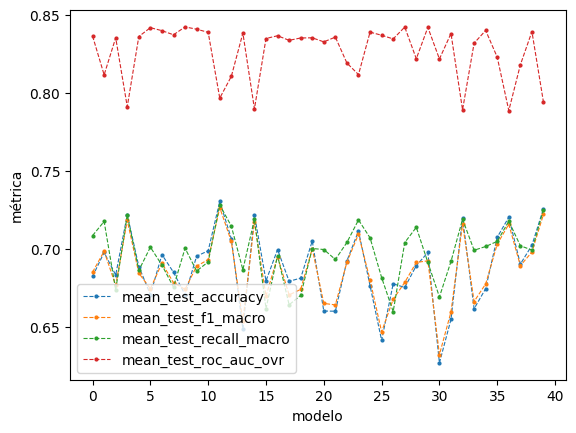

In [173]:
labels=[ key for key in randomcv_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(randomcv_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)
    x_linea=np.argmax(randomcv_fit.cv_results_[k])
    #plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey') #Comentar para ver bien el legend con colores

plt.xlabel("modelo", fontsize=10)
plt.ylabel("métrica", fontsize=10)
plt.legend(labels, loc=3)
plt.show()

In [174]:
#Elijo el modelo con mayor puntaje de Accuracy

params_elegidos=randomcv_fit.cv_results_['params'][np.argmax(randomcv_fit.cv_results_['mean_test_f1_macro'])]
params_elegidos

{'splitter': 'best',
 'min_samples_leaf': 1,
 'criterion': 'entropy',
 'class_weight': None}

## Evaluación rendimiento

Como la métrica que nos interesa es F1 porque combina recall y precisión, es útil para la clasificación multiclase y un buen puntaje F1 significa que el modelo está evitando los falsos positivos y falsos negativos.

In [175]:
kfoldcv = StratifiedKFold(n_splits = 10)

arbolcv = tree.DecisionTreeClassifier(**params_elegidos)

resultados = cross_validate(arbolcv, x_train, y_train, cv=kfoldcv, scoring=f1_macro_scorer, return_estimator=True)

resultados


{'fit_time': array([0.64866638, 0.64009166, 0.64167166, 0.85622764, 0.96373558,
        0.98776484, 0.95942426, 0.63251019, 0.62814665, 0.64495349]),
 'score_time': array([0.04967999, 0.04990625, 0.04892111, 0.09096789, 0.08984685,
        0.09785032, 0.0512948 , 0.05155635, 0.0497756 , 0.05198431]),
 'estimator': [DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy'),
  DecisionTreeClassifier(criterion='entropy')],
 'test_score': array([0.72813639, 0.73408735, 0.72558266, 0.72311053, 0.7341065 ,
        0.73519525, 0.72901103, 0.71725927, 0.71469344, 0.72059657])}

In [176]:
# Obtener el índice del modelo con el mejor puntaje
mejor_modelo_index = resultados['test_score'].argmax()

# Seleccionar el mejor modelo entrenado
mejor_modelo_entrenado = resultados['estimator'][mejor_modelo_index]

mejor_modelo_entrenado

DecisionTreeClassifier(criterion='entropy')

Text(50.722222222222214, 0.5, 'True')

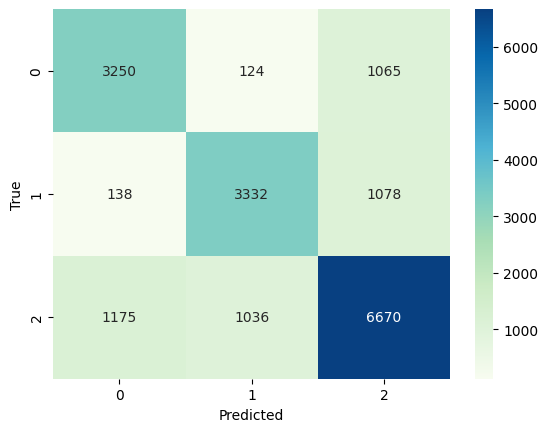

In [177]:
# Hago predecir al mejor modelo y grafico su matriz de confusion

y_pred = mejor_modelo_entrenado.predict(x_test)
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, cmap = "GnBu", annot = True, fmt = "g")
plt.xlabel('Predicted')
plt.ylabel('True')

Tener en cuenta para la matriz de confusión:


*   0: Alto
*   1: Bajo
*   2: Medio



In [183]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Alto       0.71      0.73      0.72      4439
        Bajo       0.74      0.73      0.74      4548
       Medio       0.76      0.75      0.75      8881

    accuracy                           0.74     17868
   macro avg       0.74      0.74      0.74     17868
weighted avg       0.74      0.74      0.74     17868



##Gráfico

In [179]:
features = ["latitud", "longitud", "property_type", "property_rooms",
            "property_bedrooms", "property_surface_total", "property_surface_covered", "property_price"]

#Importancia y reglas del Árbol con mejor Performance
from sklearn.tree import export_text

feat_imps = mejor_modelo_entrenado.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,features)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))
print()

reglas = export_text(mejor_modelo_entrenado, feature_names=list(features))
print(reglas)

property_price: 0.0024688413179960425
property_rooms: 0.015405935460315318
property_type: 0.024166984238155616
property_surface_covered: 0.05995910089450639
property_surface_total: 0.14033496503103068
property_bedrooms: 0.1582805880034407
longitud: 0.26627561291176677
latitud: 0.33310797214278853

|--- latitud <= -34.60
|   |--- property_surface_covered <= 0.50
|   |   |--- property_bedrooms <= 100.29
|   |   |   |--- property_bedrooms <= 75.07
|   |   |   |   |--- longitud <= -58.41
|   |   |   |   |   |--- latitud <= -34.63
|   |   |   |   |   |   |--- property_surface_total <= 23.00
|   |   |   |   |   |   |   |--- property_price <= 0.50
|   |   |   |   |   |   |   |   |--- class: Alto
|   |   |   |   |   |   |   |--- property_price >  0.50
|   |   |   |   |   |   |   |   |--- class: Medio
|   |   |   |   |   |   |--- property_surface_total >  23.00
|   |   |   |   |   |   |   |--- property_rooms <= 3.50
|   |   |   |   |   |   |   |   |--- longitud <= -58.50
|   |   |   |   |   |  

[Text(0.5, 0.9, 'latitud <= -34.598\nentropy = 1.5\nsamples = 64282\nvalue = [16070, 16070, 32142]\nclass = Alto'),
 Text(0.25, 0.7, 'property_surface_covered <= 0.5\nentropy = 1.36\nsamples = 29699\nvalue = [2873, 12624, 14202]\nclass = Alto'),
 Text(0.125, 0.5, 'property_bedrooms <= 100.289\nentropy = 0.812\nsamples = 5894\nvalue = [70, 4642, 1182]\nclass = Medio'),
 Text(0.0625, 0.3, 'property_bedrooms <= 75.065\nentropy = 1.038\nsamples = 2187\nvalue = [35, 1397, 755]\nclass = Medio'),
 Text(0.03125, 0.1, '\n  (...)  \n'),
 Text(0.09375, 0.1, '\n  (...)  \n'),
 Text(0.1875, 0.3, 'latitud <= -34.633\nentropy = 0.591\nsamples = 3707\nvalue = [35, 3245, 427]\nclass = Medio'),
 Text(0.15625, 0.1, '\n  (...)  \n'),
 Text(0.21875, 0.1, '\n  (...)  \n'),
 Text(0.375, 0.5, 'longitud <= -58.368\nentropy = 1.368\nsamples = 23805\nvalue = [2803, 7982, 13020]\nclass = Alto'),
 Text(0.3125, 0.3, 'longitud <= -58.412\nentropy = 1.281\nsamples = 22553\nvalue = [1800, 7809, 12944]\nclass = Alto'),

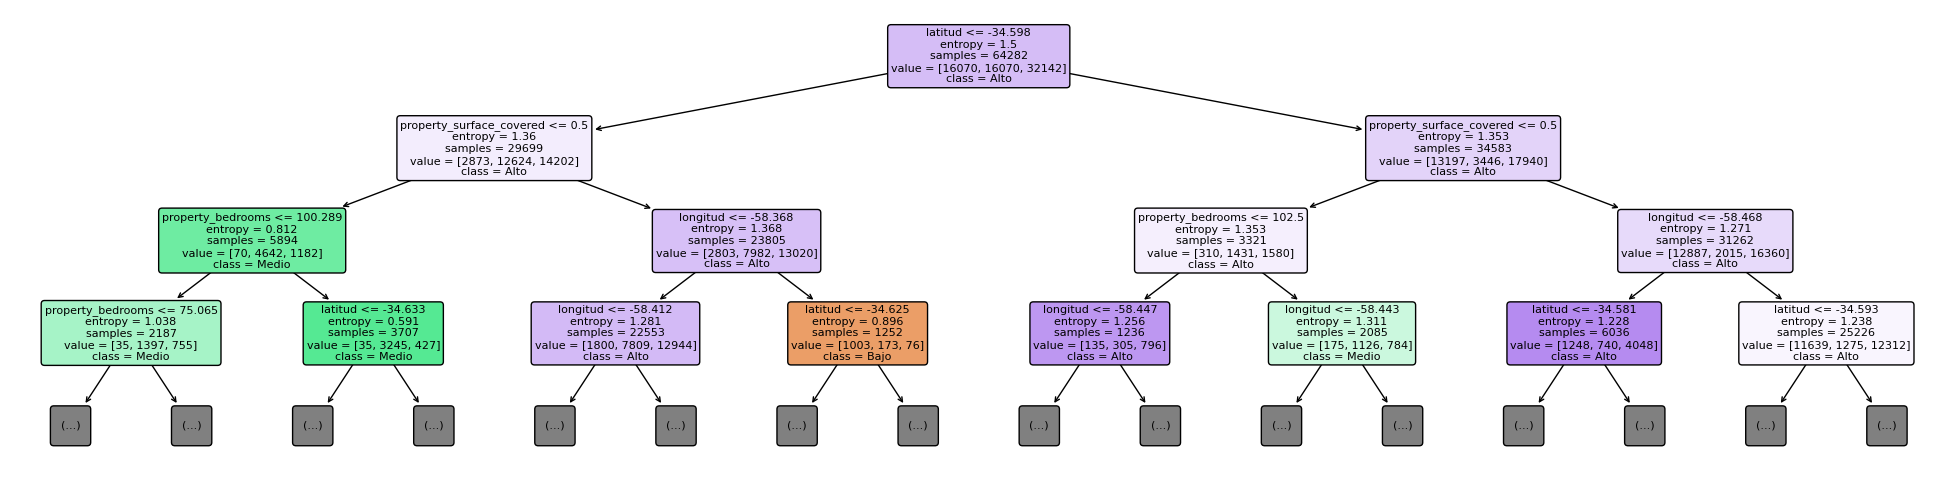

In [182]:
plt.figure(figsize=(25,6))
tree.plot_tree(mejor_modelo_entrenado,
                filled=True, rounded=True,
                feature_names=features,
                fontsize=8,
                max_depth = 3,
                class_names=['Bajo','Medio', 'Alto'])